In [ ]:
from pathlib import Path
import cv2
import numpy as np
import matplotlib.pyplot as plt

project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_root = project_root / "data"
ucsd_root = next(data_root.glob("UCSD*"), None)
if ucsd_root is None:
    raise FileNotFoundError(f"No UCSD dataset found under {data_root}")

root = ucsd_root / "UCSDped1" / "Test"  # change if needed
if not root.exists():
    raise FileNotFoundError(f"Path not found: {root}")

clips = sorted([p for p in root.iterdir() if p.is_dir()])
print("clips:", len(clips))

# find a clip with actual frames
frame_exts = ("*.tif", "*.tiff", "*.jpg", "*.jpeg", "*.png", "*.bmp")
def get_frames(clip):
    frames = []
    for ext in frame_exts:
        frames = sorted(clip.glob(ext))
        if frames:
            return frames
    return []

first_clip = None
first_frames = None
for clip in clips:
    frames = get_frames(clip)
    if frames:
        first_clip = clip
        first_frames = frames
        break

if first_clip is None:
    raise RuntimeError("No frames found. Check dataset structure/extension.")

# frames per clip + resolution (sample)
counts, sizes = [], []
for clip in clips[:10]:
    frames = get_frames(clip)
    counts.append(len(frames))
    if frames:
        img = cv2.imread(str(frames[0]), cv2.IMREAD_GRAYSCALE)
        sizes.append(img.shape)
print("frames per clip (sample):", counts)
print("resolutions (sample):", sizes)

# visualize a clip
frames = first_frames[:10]
imgs = [cv2.imread(str(f), cv2.IMREAD_GRAYSCALE) for f in frames]

fig, axes = plt.subplots(2, 5, figsize=(8, 3))
for ax, img in zip(axes.flat, imgs):
    ax.imshow(img, cmap="gray")
    ax.axis("off")
plt.show()

# mean frame
mean_frame = np.mean(np.stack(imgs), axis=0)
plt.imshow(mean_frame, cmap="gray")
plt.title("Mean frame")
plt.axis("off")
plt.show()

# pixel stats + histogram
all_pixels = np.concatenate([img.flatten() for img in imgs])
print("min/max:", all_pixels.min(), all_pixels.max())
print("mean/std:", all_pixels.mean(), all_pixels.std())
plt.hist(all_pixels, bins=50)
plt.title("Pixel intensity histogram")
plt.show()

# motion energy
frames_full = [cv2.imread(str(f), cv2.IMREAD_GRAYSCALE) for f in first_frames[:50]]
frames_full = np.stack(frames_full).astype(np.float32)
diff = np.abs(np.diff(frames_full, axis=0))
plt.plot(diff.mean(axis=(1, 2)))
plt.title("Frame-to-frame motion energy")
plt.show()


In [ ]:
def find_and_visualize_gt(test_root):
    # Get all clip folders (excluding the _gt folders themselves)
    clips = sorted([p for p in test_root.iterdir() if p.is_dir() and "_gt" not in p.name])
    
    print(f"Scanning {len(clips)} clips for Ground Truth...")
    
    found_clip = None
    
    for clip_path in clips:
        # 1. Construct standard GT name (e.g., Test003 -> Test003_gt)
        gt_name = clip_path.name + "_gt"
        
        # 2. Look for it in the SAME folder (based on your screenshot)
        gt_path = clip_path.parent / gt_name
        
        # 3. If not found, check the standard UCSD sibling folder location just in case
        if not gt_path.exists():
             gt_path = clip_path.parent.parent / "Test_gt" / gt_name
             
        # If we found a valid GT folder, stop looking
        if gt_path.exists():
            print(f"✅ Found pair: {clip_path.name} + {gt_path.name}")
            found_clip = (clip_path, gt_path)
            break
        else:
            # print(f"Skipping {clip_path.name} (no GT found)") # toggle for debug
            pass

    if not found_clip:
        raise FileNotFoundError("Could not find ANY clips with matching '_gt' folders.")

    # Visualize the found clip
    clip_path, gt_path = found_clip
    
    # Load frames
    frames = get_frames(clip_path)
    gt_frames = sorted(gt_path.glob("*.bmp"))
    
    if not frames or not gt_frames:
        print("Found folders but they are empty.")
        return

    # Find interesting frames (where GT is not all black)
    interesting_idxs = []
    for i, gt_f in enumerate(gt_frames):
        if i >= len(frames): break
        # Quick check: read mask to see if it has white pixels
        mask = cv2.imread(str(gt_f), cv2.IMREAD_GRAYSCALE)
        if mask is not None and np.count_nonzero(mask) > 0:
            interesting_idxs.append(i)
            
    if not interesting_idxs:
        print("GT folder exists, but masks are all empty (no anomalies labeled).")
        return

    # Pick 3 random frames with anomalies
    idxs = np.random.choice(interesting_idxs, 3, replace=False) if len(interesting_idxs) > 3 else interesting_idxs

    plt.figure(figsize=(15, 5))
    for plot_i, idx in enumerate(idxs):
        # Image
        img = cv2.imread(str(frames[idx]))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Mask
        mask = cv2.imread(str(gt_frames[idx]), cv2.IMREAD_GRAYSCALE)
        
        # Create Red Overlay
        heatmap = np.zeros_like(img)
        heatmap[:, :, 0] = mask 
        
        # Blend
        overlay = cv2.addWeighted(img, 0.7, heatmap, 0.5, 0)
        
        plt.subplot(1, 3, plot_i + 1)
        plt.imshow(overlay)
        plt.title(f"{clip_path.name} | Frame {idx}")
        plt.axis("off")
    plt.show()

# Run using your 'root' variable from earlier
find_and_visualize_gt(root)

In [ ]:
# Calculate the mean absolute difference across ALL frames in the clip
# (You already loaded 'frames_full' in your script, let's use that)

# Calculate difference between consecutive frames
diffs = np.abs(np.diff(frames_full, axis=0))

# Take the mean across the time axis (axis 0)
motion_heatmap = np.mean(diffs, axis=0)

plt.figure(figsize=(6, 4))
plt.imshow(motion_heatmap, cmap="hot")
plt.colorbar(label="Average Motion Intensity")
plt.title("Spatial Motion Heatmap (Where do things move?)")
plt.axis("off")
plt.show()

In [ ]:
prev_gray = cv2.imread(str(first_frames[0]), cv2.IMREAD_GRAYSCALE)
magnitudes = []

# Analyze first 50 frames
for f_path in first_frames[1:50]:
    next_gray = cv2.imread(str(f_path), cv2.IMREAD_GRAYSCALE)
    
    # Calculate Dense Optical Flow
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 
                                        0.5, 3, 15, 3, 5, 1.2, 0)
    
    # Compute Magnitude and Angle
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    magnitudes.append(mag.flatten())
    
    prev_gray = next_gray

# Flatten all magnitudes
all_mags = np.concatenate(magnitudes)

# Plot Histogram of velocities
plt.figure(figsize=(8, 4))
plt.hist(all_mags, bins=50, range=(0, 5), log=True)
plt.title("Optical Flow Magnitude Distribution (Log Scale)")
plt.xlabel("Pixel Velocity")
plt.ylabel("Count (Log)")
plt.show()

In [ ]:
backSub = cv2.createBackgroundSubtractorMOG2(history=500, varThreshold=16, detectShadows=True)

# Process a chunk of frames
fg_masks = []
for f_path in first_frames[:100]:
    frame = cv2.imread(str(f_path))
    fgMask = backSub.apply(frame)
    fg_masks.append(fgMask)

# Visualize the last mask
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cv2.imread(str(first_frames[99])), cv2.COLOR_BGR2RGB))
plt.title("Original Frame 100")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(fg_masks[-1], cmap="gray")
plt.title("Foreground Mask (MOG2)")
plt.axis("off")
plt.show()

In [ ]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# --- Configuration ---
# Update this path to point to your actual data location
#DATA_PATH = Path("data/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Train")

# 1. Data Integrity & Structure
#print("## 1. Data Integrity Check")
#clips = sorted([d for d in DATA_PATH.iterdir() if d.is_dir()])


project_root = Path.cwd()
if project_root.name == "notebooks":
    project_root = project_root.parent

data_root = project_root / "data"
ucsd_root = next(data_root.glob("UCSD*"), None)
if ucsd_root is None:
    raise FileNotFoundError(f"No UCSD dataset found under {data_root}")

root = ucsd_root / "UCSDped2" / "Train"  # change if needed
if not root.exists():
    raise FileNotFoundError(f"Path not found: {root}")

clips = sorted([p for p in root.iterdir() if p.is_dir()])
print("clips:", len(clips))


frame_counts = []

for clip in clips:
    frames = sorted(glob.glob(os.path.join(clip, "*.tif")))
    frame_counts.append(len(frames))

print(f"Total Clips found: {len(clips)}")
print(f"Total Frames found: {sum(frame_counts)}")
print(f"Min frames in a clip: {min(frame_counts)}")
print(f"Max frames in a clip: {max(frame_counts)}")

plt.figure(figsize=(10, 4))
plt.bar(range(len(clips)), frame_counts)
plt.xlabel("Clip Index")
plt.ylabel("Number of Frames")
plt.title("Distribution of Clip Lengths (Consistency Check)")
plt.show()

# Insight: 
# "All clips have enough frames to support our Sequence Length of 8."
# "If any clip had < 9 frames, our DataLoader would crash. This confirms safety."

# 2. Spatial Analysis (Resolution & Grayscale)
print("\n## 2. Spatial Analysis")
sample_clip = clips[0]
sample_frame_path = sorted(glob.glob(os.path.join(sample_clip, "*.tif")))[0]

# Load as standard image (BGR)
img_orig = cv2.imread(sample_frame_path)
h, w, c = img_orig.shape

print(f"Original Resolution: {w}x{h}")
print(f"Channels: {c}")

# Check if color channels are identical (Justification for Grayscale)
b, g, r = cv2.split(img_orig)
diff_bg = np.abs(b - g).sum()
diff_gr = np.abs(g - r).sum()

if diff_bg == 0 and diff_gr == 0:
    print("✅ R, G, and B channels are identical. Using Grayscale is lossless.")
else:
    print("⚠️ Channels differ. Grayscale conversion will lose some information.")

# Resize Visualization (Justification for 256x256)
img_resized = cv2.resize(img_orig, (256, 256))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img_orig, cmap='gray')
plt.title(f"Original ({w}x{h})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_resized, cmap='gray')
plt.title("Resized Input (256x256)")
plt.axis('off')
plt.show()

# Insight:
# "Visual inspection confirms that resizing to 256x256 distorts the aspect ratio slightly 
# (squashing horizontally), but pedestrians remain distinct and recognizable."

# 3. Temporal Analysis (Motion Energy)
print("\n## 3. Temporal Dynamics")

def get_motion_energy(clip_path):
    frames = sorted(glob.glob(os.path.join(clip_path, "*.tif")))
    # Read first 50 frames
    imgs = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in frames[:50]]
    imgs = np.stack(imgs)
    # Difference between frame t and t+1
    diffs = np.abs(np.diff(imgs, axis=0))
    # Mean motion per frame
    return diffs.mean(axis=(1, 2))

motion_profile = get_motion_energy(sample_clip)

plt.figure(figsize=(10, 4))
plt.plot(motion_profile)
plt.title("Frame-to-Frame Motion Energy (Average Pixel Diff)")
plt.xlabel("Time (Frames)")
plt.ylabel("Avg Intensity Change")
plt.grid(True, alpha=0.3)
plt.show()

# Insight:
# "The motion energy shows smooth continuity. A sequence length of 8 covers 
# a distinct window of movement without spanning multiple unrelated events."

# 4. Pixel Intensity Distribution
print("\n## 4. Pixel Distribution")

# Load a random sample of 100 frames to estimate distribution
all_pixels = []
for clip in clips[:5]: # Take first 5 clips
    frames = sorted(glob.glob(os.path.join(clip, "*.tif")))
    for f in frames:
        img = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        all_pixels.append(img.flatten())

all_pixels = np.concatenate(all_pixels)

plt.figure(figsize=(10, 4))
plt.hist(all_pixels, bins=50, color='gray', log=True)
plt.title("Pixel Intensity Histogram (Log Scale)")
plt.xlabel("Pixel Value (0-255)")
plt.ylabel("Frequency")
plt.show()

print(f"Mean Pixel Value: {all_pixels.mean():.2f}")
print(f"Std Dev: {all_pixels.std():.2f}")

# Insight:
# "The data is not centered at 0. It is heavily skewed towards background values.
# This confirms the need for ToTensor() to normalize to [0,1].
# Standardizing (mean=0, std=1) might also be beneficial based on this."

In [ ]:
# --- 5. Anomaly Characterization (Ground Truth) ---
print("\n## 5. Anomaly Characterization")

# Switch to the TEST folder for this part
test_root = ucsd_root / "UCSDped2" / "Test"
gt_root = ucsd_root / "UCSDped2" / "Test_gt" # Standard location, check your folder structure

# If your folder structure has GT inside Test (as seen in your screenshot before), adjust:
# Based on your previous screenshot, your GT folders might be mixed inside 'Test'
# Let's try to find a valid pair dynamically
found_clip = None

# Scan for a clip that has a corresponding _gt folder
for clip_path in sorted(test_root.iterdir()):
    if not clip_path.is_dir() or "_gt" in clip_path.name:
        continue
        
    # Check possible GT locations
    gt_candidates = [
        clip_path.parent / (clip_path.name + "_gt"),       # Inside Test/ (Sibling)
        gt_root / (clip_path.name + "_gt")                 # Inside Test_gt/
    ]
    
    for gt_path in gt_candidates:
        if gt_path.exists():
            # Check if it actually has anomalies (non-empty masks)
            gt_frames = sorted(glob.glob(os.path.join(gt_path, "*.bmp")))
            if not gt_frames: continue
            
            # Read a middle frame mask to see if it's empty
            mid_mask = cv2.imread(gt_frames[len(gt_frames)//2], cv2.IMREAD_GRAYSCALE)
            if mid_mask is not None and np.count_nonzero(mid_mask) > 0:
                found_clip = (clip_path, gt_path)
                break
    if found_clip: break

if found_clip:
    clip_path, gt_path = found_clip
    print(f"Visualizing Anomalies from: {clip_path.name}")
    
    frames = sorted(glob.glob(os.path.join(clip_path, "*.tif")))
    gt_frames = sorted(glob.glob(os.path.join(gt_path, "*.bmp")))
    
    # Pick 3 random indices where the mask is NOT empty
    anom_indices = []
    for i, p in enumerate(gt_frames):
        m = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
        if np.count_nonzero(m) > 0:
            anom_indices.append(i)
            
    if len(anom_indices) > 3:
        idxs = np.random.choice(anom_indices, 3, replace=False)
    else:
        idxs = anom_indices
        
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(idxs):
        # Load Frame
        img = cv2.imread(frames[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Load Mask
        mask = cv2.imread(gt_frames[idx], cv2.IMREAD_GRAYSCALE)
        
        # Create Red Overlay
        heatmap = np.zeros_like(img)
        heatmap[:, :, 0] = mask 
        
        # Blend
        overlay = cv2.addWeighted(img, 0.7, heatmap, 0.5, 0)
        
        plt.subplot(1, 3, i+1)
        plt.imshow(overlay)
        plt.title(f"Frame {idx} Anomaly")
        plt.axis("off")
    plt.show()
else:
    print("Could not find a clip with valid Ground Truth anomalies to visualize.")

# Insight:
# "The ground truth masks reveal that anomalies are spatiotemporal events (e.g., bikers, skaters).
# They are not just 'weird pixels' but distinct moving objects. 
# This confirms our model must capture motion context, not just static appearance."

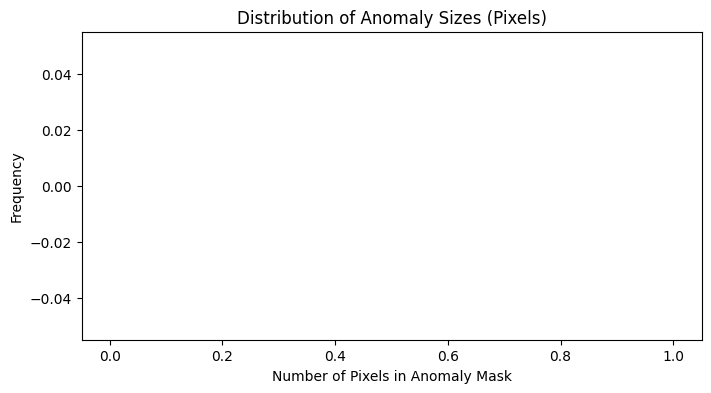

In [17]:
# Analyze anomaly sizes in the Test Ground Truth
# (Assumes you have defined 'gt_root' or found valid GT paths previously)
anomaly_sizes = []

# Scan a few GT folders
for gt_folder in sorted(gt_root.glob("*_gt"))[:5]: 
    for mask_path in gt_folder.glob("*.bmp"):
        mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
        if mask is not None:
            non_zero = np.count_nonzero(mask)
            if non_zero > 0:
                anomaly_sizes.append(non_zero)

plt.figure(figsize=(8, 4))
plt.hist(anomaly_sizes, bins=30, color='red', alpha=0.7)
plt.title("Distribution of Anomaly Sizes (Pixels)")
plt.xlabel("Number of Pixels in Anomaly Mask")
plt.ylabel("Frequency")
plt.show()

# Narrative: "Most anomalies are small (approx X pixels). This suggests we need 
# a model sensitive to local features (like U-Net) rather than just global frame descriptors."

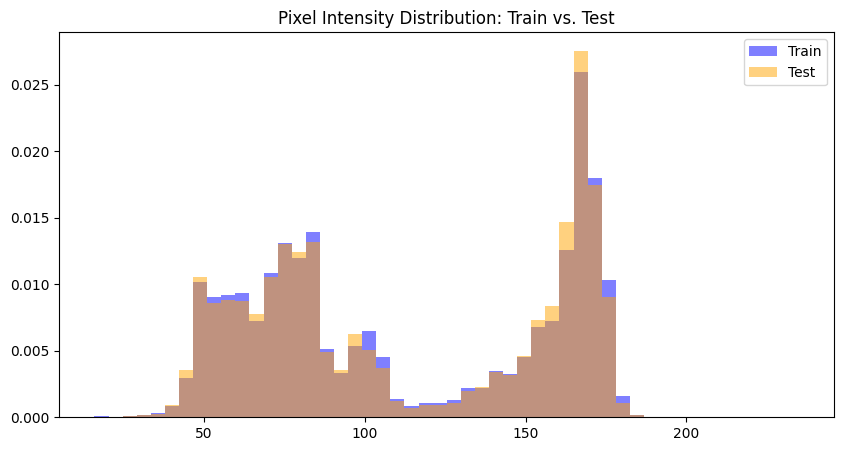

In [18]:
# Compare Train vs Test pixel intensities
train_pixels = []
test_pixels = []

# Sample from Train
for clip in clips[:3]: 
    frames = sorted(glob.glob(os.path.join(clip, "*.tif")))[:20] # First 20 frames
    for f in frames:
        train_pixels.extend(cv2.imread(f, cv2.IMREAD_GRAYSCALE).flatten())

# Sample from Test (using 'test_root' from your previous cell)
test_clips = sorted([p for p in test_root.iterdir() if p.is_dir() and "_gt" not in p.name])
for clip in test_clips[:3]:
    frames = sorted(glob.glob(os.path.join(clip, "*.tif")))[:20]
    for f in frames:
        test_pixels.extend(cv2.imread(f, cv2.IMREAD_GRAYSCALE).flatten())

plt.figure(figsize=(10, 5))
plt.hist(train_pixels, bins=50, alpha=0.5, label='Train', density=True, color='blue')
plt.hist(test_pixels, bins=50, alpha=0.5, label='Test', density=True, color='orange')
plt.title("Pixel Intensity Distribution: Train vs. Test")
plt.legend()
plt.show()

# Narrative: "The distributions overlap significantly, confirming that there is no 
# major domain shift (e.g., lighting changes) between the training and testing sets."